# Bank data Analysis
## Geleshko Dmytro
## 
## Imports

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Dataframe

In [2]:
df = pd.read_csv("data/creditcard.csv", sep=",")
df["Time"] = df["Time"] % 86400
#df = df.loc[::10,:]
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,86386.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,86387.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,86388.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,86388.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Ploting Data

<AxesSubplot:xlabel='Class', ylabel='count'>

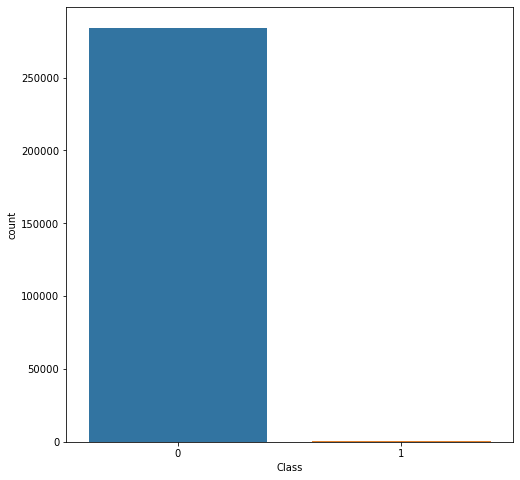

In [4]:
plt.rcParams["figure.figsize"] = (8,8)
sns.countplot(data=df, x="Class")

<BarContainer object of 492 artists>

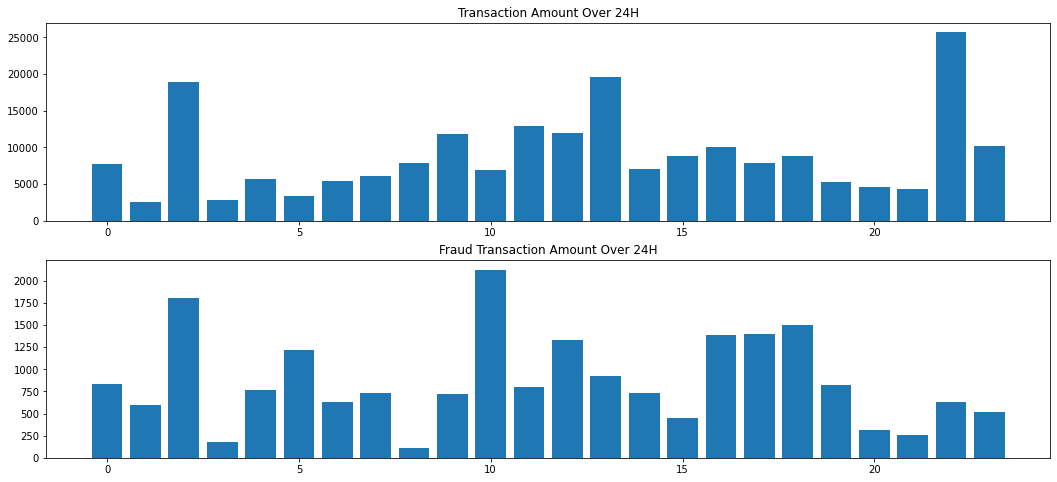

In [5]:
plt.rcParams["figure.figsize"] = (18,8)
fig, axes = plt.subplots(2)
axes[0].set_title("Transactions Amount Over 24H")
axes[0].bar((df[df["Class"] == 0])["Time"]//3600, (df[df["Class"] == 0])["Amount"])
axes[1].set_title("Fraud Transactions Amount Over 24H")
axes[1].bar((df[df["Class"] == 1])["Time"]//3600, (df[df["Class"] == 1])["Amount"])

<AxesSubplot:>

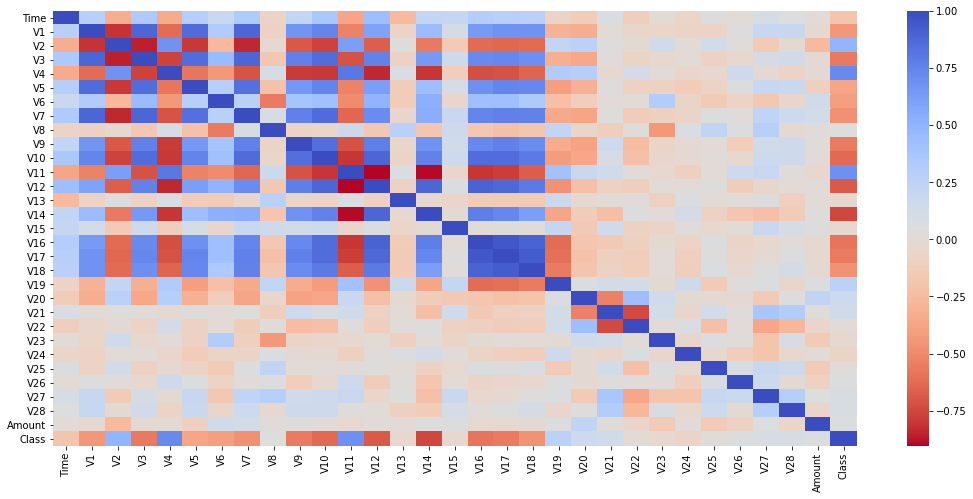

In [6]:
df_corr = (df[df["Class"] == 0].sample(frac=1)).head(df["Class"].sum())
df_corr = pd.concat([df_corr, df[df["Class"] == 1]])
sns.heatmap(df_corr.corr(), cmap='coolwarm_r')

### Results:
- Non 'nan' values
- Imbalanced classes
- Most fraud transactions take place when there are little transactions overall
- Positive Correlation: V2 V4 V11
- Negative Correlation: V10 V12 V14

## Features

In [7]:
col_id = 0
for col in df.columns:
    print(col_id,"\t", col)
    col_id+=1
print("Total size:", df.shape)

0 	 Time
1 	 V1
2 	 V2
3 	 V3
4 	 V4
5 	 V5
6 	 V6
7 	 V7
8 	 V8
9 	 V9
10 	 V10
11 	 V11
12 	 V12
13 	 V13
14 	 V14
15 	 V15
16 	 V16
17 	 V17
18 	 V18
19 	 V19
20 	 V20
21 	 V21
22 	 V22
23 	 V23
24 	 V24
25 	 V25
26 	 V26
27 	 V27
28 	 V28
29 	 Amount
30 	 Class
Total size: (284807, 31)


## To numpy

In [8]:
X = df.loc[:, df.columns != "Class"].to_numpy()
y = df["Class"].to_numpy()
print("X:", X.shape, "\ny:", y.shape)

X: (284807, 30) 
y: (284807,)


## Normalizing

In [9]:
X = normalize(X, axis=0, norm="l2")

for i in range(X.shape[1]):
    print(X[:,i].min(), " - ", X[:,i].max())

0.0  -  0.002869886476963672
-0.053962910591939486  -  0.002348537783196583
-0.0825136026471437  -  0.025029835308250384
-0.059721450137869  -  0.011595099056306577
-0.007521305494915343  -  0.02233341445870133
-0.15441680219265602  -  0.04724640166563607
-0.03679416638023733  -  0.10309709655059601
-0.06597558381337568  -  0.18265532843220367
-0.11486904846452954  -  0.031389128546332995
-0.022912930660308757  -  0.026598575711667703
-0.0423141197478085  -  0.040863177534470115
-0.00880712897316759  -  0.022064138402128074
-0.035037703160963767  -  0.014718145574035344
-0.010904413686810853  -  0.013417830461228531
-0.03755909678472167  -  0.020577137884413194
-0.009210114428596674  -  0.01817426571279719
-0.030215769659183794  -  0.03702723340795907
-0.05551422883762676  -  0.02041515199815069
-0.02123520089775826  -  0.011269710526157772
-0.01660454989907073  -  0.012871950581476542
-0.13246209715087376  -  0.09581640481318228
-0.08885414109326654  -  0.06939587681157222
-0.02823010

## Test/Train. Class Balance
Define a function to print importand information about given data

In [10]:
def balance_size_fraud(heading, labels):
    print("_" + heading)
    print("Balance:", 100 - labels.sum() * 100 / labels.shape[0])
    print("Size:", labels.shape[0])
    print("Fraud:", labels.sum(), "\n")

In [11]:
balance_size_fraud("df", y)

_df
Balance: 99.827251436938
Size: 284807
Fraud: 492 



Spliting the data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

balance_size_fraud("train", y_train)
balance_size_fraud("test", y_test)

_train
Balance: 99.82224758059206
Size: 227845
Fraud: 405 

_test
Balance: 99.84726659878515
Size: 56962
Fraud: 87 



<module 'matplotlib.pyplot' from 'E:\\Programs\\Anaconda\\envs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

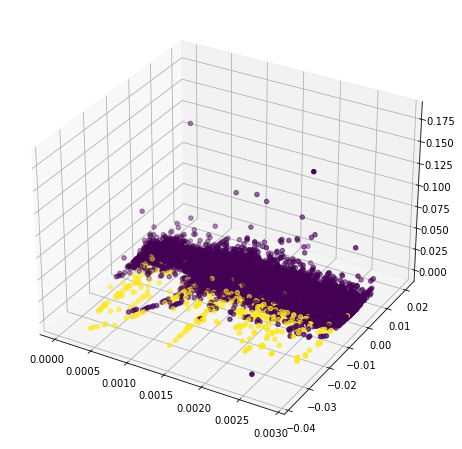

In [13]:
plt.axes(projection='3d').scatter3D(X_train[:,0], X_train[:,14], X_train[:,29], c=y_train)
plt

## Samples

### Undersample

In [14]:
b_coef = 2

In [15]:
#X_train_random = (X_train[y_train_class0_mask, :])[:y_train.sum(), :]
#y_train_random = np.zeros((X_train_random.shape[0],))
#X_train_random = np.append(X_train_random, X_train[y_train_class1_mask], axis=0)
#y_train_random = np.append(y_train_random, np.ones((y_train.sum(),)), axis=0)

undersampler = NearMiss(sampling_strategy=0.0017*b_coef)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

print("X_train_undersampled.shape: ", X_train_undersampled.shape)
print("y_train_undersampled.shape: ", y_train_undersampled.shape)

balance_size_fraud("train_undersample", y_train_undersampled)

X_train_undersampled.shape:  (119522, 30)
y_train_undersampled.shape:  (119522,)
_train_undersample
Balance: 99.66115024848982
Size: 119522
Fraud: 405 



<module 'matplotlib.pyplot' from 'E:\\Programs\\Anaconda\\envs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

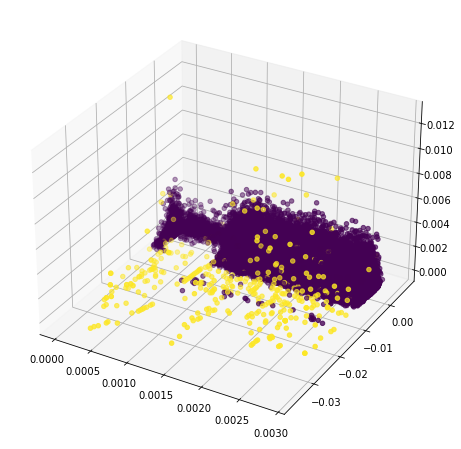

In [16]:
plt.axes(projection='3d').scatter3D(X_train_undersampled[:,0],
                                    X_train_undersampled[:,14],
                                    X_train_undersampled[:,29],
                                    c=y_train_undersampled)
plt

### Oversample

In [17]:
oversampler = SMOTE(sampling_strategy=0.0017*b_coef)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

print("X_train_oversampled.shape: ", X_train_oversampled.shape)
print("y_train_oversampled.shape: ", y_train_oversampled.shape)

balance_size_fraud("train_oversampled", y_train_oversampled)

X_train_oversampled.shape:  (228213, 30)
y_train_oversampled.shape:  (228213,)
_train_oversampled
Balance: 99.66128134681198
Size: 228213
Fraud: 773 



<module 'matplotlib.pyplot' from 'E:\\Programs\\Anaconda\\envs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

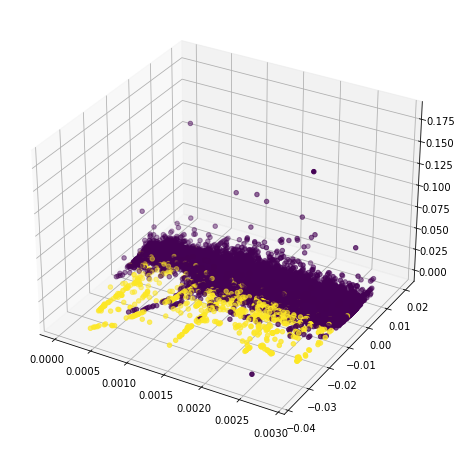

In [18]:
plt.axes(projection='3d').scatter3D(X_train_oversampled[:,0],
                                    X_train_oversampled[:,14],
                                    X_train_oversampled[:,29],
                                    c=y_train_oversampled)
plt

### Combined method

In [19]:
comb = NearMiss(sampling_strategy=0.0017*math.sqrt(b_coef))
X_train_combined, y_train_combined = comb.fit_resample(X_train, y_train)
comb = SMOTE(sampling_strategy=0.0017*b_coef)
X_train_combined, y_train_combined = comb.fit_resample(X_train_combined, y_train_combined)

print("X_train_combined.shape: ", X_train_combined.shape)
print("y_train_combined.shape: ", y_train_combined.shape)

balance_size_fraud("train_combined", y_train_combined)

X_train_combined.shape:  (169029, 30)
y_train_combined.shape:  (169029,)
_train_combined
Balance: 99.66159653077283
Size: 169029
Fraud: 572 



<module 'matplotlib.pyplot' from 'E:\\Programs\\Anaconda\\envs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

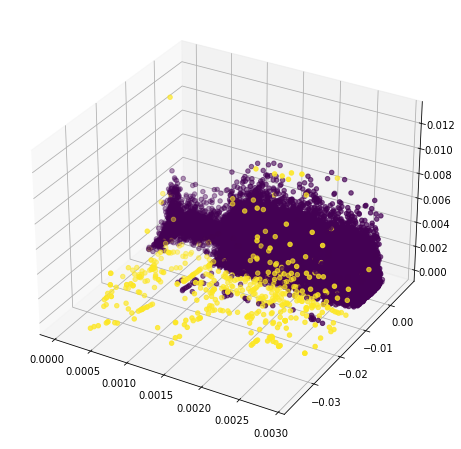

In [20]:
plt.axes(projection='3d').scatter3D(X_train_combined[:,0],
                                    X_train_combined[:,14],
                                    X_train_combined[:,29],
                                    c=y_train_combined)
plt

## Using Different Splits of Data To Compare Models

#### Training Sets
- X_train (200k/500)
- X_train_undersampled (500/500)
- X_train_oversampled (200k/200k)
- X_train_combined (100k/100k)

#### Testing Set
- X_test (50k/100)

In [104]:
def get_neural_model():
    return keras.Sequential([
        layers.Input(shape=(30)),
        layers.Dense(30, activation="relu"),
        layers.Dense(30, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

In [105]:
def compile_model(model, X_train, y_train):
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(lr=0.001)
    )
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

In [122]:
def get_classifiers(X_train, y_train, balanced=None):
    classifiers = {}

    # Logistic Regression
    log_reg_params = {
        "penalty": ["none"], # "l1", "l2"
        "max_iter": [5000], # 100, 500, 1000, 5000, 10000
        "solver": ["lbfgs"],
        "class_weight": [balanced]
    }
    
    grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
    grid_log_reg.fit(X_train, y_train)
    # Save best
    classifiers["LogisiticRegression"] = grid_log_reg.best_estimator_
    #print("LogisiticRegression", grid_log_reg.best_params_)
    
    # Decision Tree
    tree_params = {
        "criterion": ["gini"], # "entrophy"
        "max_depth": [14],  # 2, 4, 6, 8, 10, 12, 14, 16
        "min_samples_leaf": [5], # 3, 5, 8, ..., 40
        "class_weight": [balanced]
    }
    
    grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
    grid_tree.fit(X_train, y_train)
    # Save best
    classifiers["DecisionTreeClassifier"] = grid_tree.best_estimator_
    #print("DecisionTreeClassifier", grid_tree.best_params_)
    
    #Neural Network
    classifiers["NeuralNetwork"] = get_neural_model()
    compile_model(classifiers["NeuralNetwork"], X_train, y_train)
    
    return classifiers

In [127]:
def get_model_score(X_train, X_test, y_train, y_test, classifiers):
    scores = {}
    print("\t\t\tPRECISION\tRECALL\t\tF1")
    for name, classifier in classifiers.items():
        #test score
        predicted = [int(i > 0.5) for i in classifier.predict(X_train)]
        train_precision = round(precision_score(y_train, predicted) * 100, 3)
        train_recall = round(recall_score(y_train, predicted) * 100, 3)
        train_f1 = round(f1_score(y_train, predicted) * 100, 3)
        
        #train score
        predicted = [int(i > 0.5) for i in classifier.predict(X_test)]
        test_precision = round(precision_score(y_test, predicted) * 100, 3)
        test_recall = round(recall_score(y_test, predicted) * 100, 3)
        test_f1 = round(f1_score(y_test, predicted) * 100, 3)
        
        print(name +"\n\t\tTRAIN\t"
              + str(train_precision) + "\t\t" + str(train_recall) + "\t\t" + str(train_f1) + "\n\t\tTEST\t"
              + str(test_precision) + "\t\t" + str(test_recall) + "\t\t" + str(test_f1))
        
        scores[name] = [train_precision, train_recall, train_f1, test_precision, test_recall, test_f1]
    return scores

In [128]:
print("\n ORIGINAL \n")
models = get_classifiers(X_train, y_train)
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 ORIGINAL 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	88.926		65.432		75.391
		TEST	82.759		55.172		66.207
DecisionTreeClassifier
		TRAIN	96.034		83.704		89.446
		TEST	88.235		68.966		77.419
NeuralNetwork
		TRAIN	78.972		83.457		81.152
		TEST	74.713		74.713		74.713


{'LogisiticRegression': [88.926, 65.432, 75.391, 82.759, 55.172, 66.207],
 'DecisionTreeClassifier': [96.034, 83.704, 89.446, 88.235, 68.966, 77.419],
 'NeuralNetwork': [78.972, 83.457, 81.152, 74.713, 74.713, 74.713]}

In [129]:
print("\n UNDERSAMPLED \n")
models = get_classifiers(X_train_undersampled, y_train_undersampled)
get_model_score(X_train_undersampled, X_test,
                y_train_undersampled, y_test,
                models)


 UNDERSAMPLED 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	96.275		82.963		89.125
		TEST	4.606		75.862		8.684
DecisionTreeClassifier
		TRAIN	96.237		88.395		92.149
		TEST	3.481		79.31		6.67
NeuralNetwork
		TRAIN	91.076		85.679		88.295
		TEST	8.712		79.31		15.7


{'LogisiticRegression': [96.275, 82.963, 89.125, 4.606, 75.862, 8.684],
 'DecisionTreeClassifier': [96.237, 88.395, 92.149, 3.481, 79.31, 6.67],
 'NeuralNetwork': [91.076, 85.679, 88.295, 8.712, 79.31, 15.7]}

In [130]:
print("\n OVERSAMPLED \n")
models = get_classifiers(X_train_oversampled, y_train_oversampled)
get_model_score(X_train_oversampled, X_test,
                y_train_oversampled, y_test,
                models)


 OVERSAMPLED 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	89.844		74.386		81.387
		TEST	80.282		65.517		72.152
DecisionTreeClassifier
		TRAIN	97.278		87.84		92.318
		TEST	85.135		72.414		78.261
NeuralNetwork
		TRAIN	91.763		82.147		86.689
		TEST	81.013		73.563		77.108


{'LogisiticRegression': [89.844, 74.386, 81.387, 80.282, 65.517, 72.152],
 'DecisionTreeClassifier': [97.278, 87.84, 92.318, 85.135, 72.414, 78.261],
 'NeuralNetwork': [91.763, 82.147, 86.689, 81.013, 73.563, 77.108]}

In [131]:
print("\n COMBINED \n")
models = get_classifiers(X_train_combined, y_train_combined)
get_model_score(X_train_combined, X_test,
                y_train_combined, y_test,
                models)


 COMBINED 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	93.279		80.07		86.171
		TEST	8.245		71.264		14.779
DecisionTreeClassifier
		TRAIN	96.139		87.063		91.376
		TEST	4.403		80.46		8.348
NeuralNetwork
		TRAIN	90.875		83.566		87.067
		TEST	15.752		75.862		26.087


{'LogisiticRegression': [93.279, 80.07, 86.171, 8.245, 71.264, 14.779],
 'DecisionTreeClassifier': [96.139, 87.063, 91.376, 4.403, 80.46, 8.348],
 'NeuralNetwork': [90.875, 83.566, 87.067, 15.752, 75.862, 26.087]}

In [132]:
print("\n BALANCED - 0.5 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 0.5})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 0.5 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	87.815		51.605		65.008
		TEST	82.0		47.126		59.854
DecisionTreeClassifier
		TRAIN	97.872		79.506		87.738
		TEST	90.625		66.667		76.821
NeuralNetwork
		TRAIN	87.805		80.0		83.721
		TEST	85.333		73.563		79.012


{'LogisiticRegression': [87.815, 51.605, 65.008, 82.0, 47.126, 59.854],
 'DecisionTreeClassifier': [97.872, 79.506, 87.738, 90.625, 66.667, 76.821],
 'NeuralNetwork': [87.805, 80.0, 83.721, 85.333, 73.563, 79.012]}

In [133]:
print("\n BALANCED - 0.75 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 0.75})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 0.75 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	88.809		60.741		72.141
		TEST	82.143		52.874		64.336
DecisionTreeClassifier
		TRAIN	96.034		83.704		89.446
		TEST	90.141		73.563		81.013
NeuralNetwork
		TRAIN	87.838		80.247		83.871
		TEST	85.333		73.563		79.012


{'LogisiticRegression': [88.809, 60.741, 72.141, 82.143, 52.874, 64.336],
 'DecisionTreeClassifier': [96.034, 83.704, 89.446, 90.141, 73.563, 81.013],
 'NeuralNetwork': [87.838, 80.247, 83.871, 85.333, 73.563, 79.012]}

In [134]:
print("\n BALANCED - 2 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 2})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 2 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	83.607		75.556		79.377
		TEST	81.429		65.517		72.611
DecisionTreeClassifier
		TRAIN	91.969		87.654		89.76
		TEST	80.233		79.31		79.769
NeuralNetwork
		TRAIN	87.903		80.741		84.17
		TEST	84.211		73.563		78.528


{'LogisiticRegression': [83.607, 75.556, 79.377, 81.429, 65.517, 72.611],
 'DecisionTreeClassifier': [91.969, 87.654, 89.76, 80.233, 79.31, 79.769],
 'NeuralNetwork': [87.903, 80.741, 84.17, 84.211, 73.563, 78.528]}

In [135]:
print("\n BALANCED - 5 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 5})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 5 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	81.188		80.988		81.088
		TEST	77.778		72.414		75.0
DecisionTreeClassifier
		TRAIN	75.644		94.321		83.956
		TEST	56.098		79.31		65.714
NeuralNetwork
		TRAIN	86.352		81.235		83.715
		TEST	82.051		73.563		77.576


{'LogisiticRegression': [81.188, 80.988, 81.088, 77.778, 72.414, 75.0],
 'DecisionTreeClassifier': [75.644, 94.321, 83.956, 56.098, 79.31, 65.714],
 'NeuralNetwork': [86.352, 81.235, 83.715, 82.051, 73.563, 77.576]}

In [136]:
print("\n BALANCED - 10 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 10})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 10 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	78.472		83.704		81.004
		TEST	73.034		74.713		73.864
DecisionTreeClassifier
		TRAIN	69.735		97.284		81.237
		TEST	50.37		78.161		61.261
NeuralNetwork
		TRAIN	87.805		80.0		83.721
		TEST	85.333		73.563		79.012


{'LogisiticRegression': [78.472, 83.704, 81.004, 73.034, 74.713, 73.864],
 'DecisionTreeClassifier': [69.735, 97.284, 81.237, 50.37, 78.161, 61.261],
 'NeuralNetwork': [87.805, 80.0, 83.721, 85.333, 73.563, 79.012]}

In [137]:
print("\n BALANCED - 20 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 20})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 20 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	70.782		84.938		77.217
		TEST	65.0		74.713		69.519
DecisionTreeClassifier
		TRAIN	69.504		96.79		80.908
		TEST	51.538		77.011		61.751
NeuralNetwork
		TRAIN	87.701		80.988		84.211
		TEST	83.117		73.563		78.049


{'LogisiticRegression': [70.782, 84.938, 77.217, 65.0, 74.713, 69.519],
 'DecisionTreeClassifier': [69.504, 96.79, 80.908, 51.538, 77.011, 61.751],
 'NeuralNetwork': [87.701, 80.988, 84.211, 83.117, 73.563, 78.049]}

In [138]:
print("\n BALANCED - 50 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 50})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 50 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	56.683		86.914		68.616
		TEST	51.88		79.31		62.727
DecisionTreeClassifier
		TRAIN	71.248		97.284		82.255
		TEST	58.12		78.161		66.667
NeuralNetwork
		TRAIN	86.579		81.235		83.822
		TEST	82.051		73.563		77.576


{'LogisiticRegression': [56.683, 86.914, 68.616, 51.88, 79.31, 62.727],
 'DecisionTreeClassifier': [71.248, 97.284, 82.255, 58.12, 78.161, 66.667],
 'NeuralNetwork': [86.579, 81.235, 83.822, 82.051, 73.563, 77.576]}

In [139]:
print("\n BALANCED - 100 \n")
models = get_classifiers(X_train, y_train, {0: 1, 1: 100})
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - 100 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	32.747		87.407		47.645
		TEST	29.583		81.609		43.425
DecisionTreeClassifier
		TRAIN	68.557		98.519		80.851
		TEST	47.518		77.011		58.772
NeuralNetwork
		TRAIN	88.056		78.272		82.876
		TEST	85.333		73.563		79.012


{'LogisiticRegression': [32.747, 87.407, 47.645, 29.583, 81.609, 43.425],
 'DecisionTreeClassifier': [68.557, 98.519, 80.851, 47.518, 77.011, 58.772],
 'NeuralNetwork': [88.056, 78.272, 82.876, 85.333, 73.563, 79.012]}

In [140]:
print("\n BALANCED - DEF \n")
models = get_classifiers(X_train, y_train, "balanced")
get_model_score(X_train, X_test,
                y_train, y_test,
                models)


 BALANCED - DEF 

			PRECISION	RECALL		F1
LogisiticRegression
		TRAIN	7.354		92.346		13.622
		TEST	6.312		87.356		11.774
DecisionTreeClassifier
		TRAIN	66.069		100.0		79.568
		TEST	45.946		78.161		57.872
NeuralNetwork
		TRAIN	84.772		82.469		83.605
		TEST	80.247		74.713		77.381


{'LogisiticRegression': [7.354, 92.346, 13.622, 6.312, 87.356, 11.774],
 'DecisionTreeClassifier': [66.069, 100.0, 79.568, 45.946, 78.161, 57.872],
 'NeuralNetwork': [84.772, 82.469, 83.605, 80.247, 74.713, 77.381]}